<a href="https://colab.research.google.com/github/Sathwik2410/L00187609_Dissertation_September_2025/blob/main/HateBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch


In [ ]:
df=pd.read_csv("/content/cleaned_data (1).csv",sep=',')
df=df.dropna()
print(df['Label'].value_counts())


Label
not_cyberbullying    2002
cyberbullying        1911
Name: count, dtype: int64


In [ ]:
!pip install transformers

!pip install SentencePiece

In [ ]:
from transformers import AutoTokenizer, AutoModel


tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
model = AutoModel.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")

tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True,max_length=40,truncation=True )))

max_len = 0
for i in tokenized.values:
  if len(i) > max_len:
    max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask[0])
attention_mask.shape

input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
  last_hidden_states =model(input_ids, attention_mask=attention_mask)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


In [ ]:
"""prediction model"""

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import re
import nltk


In [ ]:
bertembedding=last_hidden_states[0][:,11,:].numpy()
print(bertembedding)

bertembedding2 = bertembedding.reshape(-1, 768, 1)
print((bertembedding2.shape))
print(bertembedding2)

y = df['Label']

y = np.array(list(map(lambda x: 1 if x=="cyberbullying" else 0, y)))

X_features, Y_features, X_labels, Y_labels = train_test_split(bertembedding2, y,  test_size=0.5,random_state=50,stratify=y)

model_bert = Sequential()
model_bert.add(Bidirectional(LSTM(60, return_sequences=True)))
model_bert.add(Dropout(0.3))
model_bert.add(Bidirectional(LSTM(20)))
model_bert.add(Dropout(0.2))
model_bert.add(Dense(20, activation='relu'))
model_bert.add(Dropout(0.4))
model_bert.add(Dense(1, activation='sigmoid'))
model_bert.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history=model_bert.fit(X_features, X_labels,batch_size=100, epochs = 100)


[[ 0.51317763 -0.6816387  -0.42129007 ... -0.31105027  0.15325636
  -0.7437197 ]
 [-0.14184493 -0.03584553  0.09313644 ...  0.26266992  0.5963002
   0.05364925]
 [-0.05046272  0.1788751   0.01531989 ...  0.46499568  0.6283594
  -0.02793776]
 ...
 [ 0.4449659  -0.43354344 -0.35538855 ... -0.7271225   0.20786245
  -0.7797368 ]
 [ 0.8820026  -0.04180167 -0.17533556 ... -0.3764412   0.01425379
  -0.21606375]
 [ 0.6764447  -0.43062907 -0.2496095  ... -0.43319404 -0.05777716
  -0.66382134]]
(3913, 768, 1)
[[[ 0.51317763]
  [-0.6816387 ]
  [-0.42129007]
  ...
  [-0.31105027]
  [ 0.15325636]
  [-0.7437197 ]]

 [[-0.14184493]
  [-0.03584553]
  [ 0.09313644]
  ...
  [ 0.26266992]
  [ 0.5963002 ]
  [ 0.05364925]]

 [[-0.05046272]
  [ 0.1788751 ]
  [ 0.01531989]
  ...
  [ 0.46499568]
  [ 0.6283594 ]
  [-0.02793776]]

 ...

 [[ 0.4449659 ]
  [-0.43354344]
  [-0.35538855]
  ...
  [-0.7271225 ]
  [ 0.20786245]
  [-0.7797368 ]]

 [[ 0.8820026 ]
  [-0.04180167]
  [-0.17533556]
  ...
  [-0.3764412 ]
  [

62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1001
           1       0.87      0.72      0.79       956

    accuracy                           0.81      1957
   macro avg       0.82      0.81      0.81      1957
weighted avg       0.82      0.81      0.81      1957



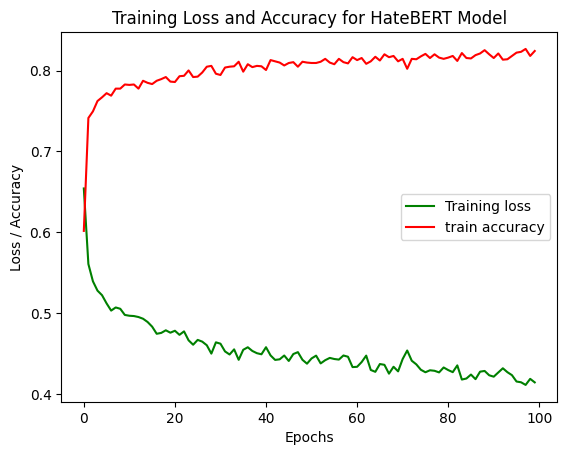

In [ ]:
from sklearn.metrics import classification_report
y_pred = model_bert.predict(Y_features)
y_predN=np.round(y_pred)
print(classification_report(Y_labels, y_predN))

train_loss = history.history['loss']
train_acc = history.history['accuracy']

epochs = range(0, 100)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs,train_acc,'r', label='train accuracy')

plt.title('Training Loss and Accuracy for HateBERT Model')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

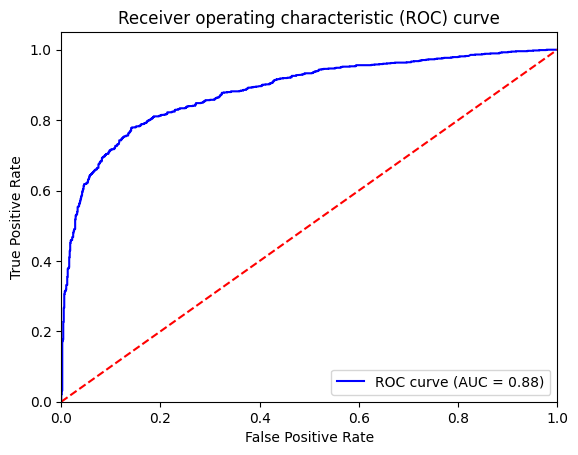

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(Y_labels, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()